In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
conn = sqlite3.connect('fsa_new.db')

In [4]:
def plot_confusion_matrix(y_true, y_pred, normalize=False,
                          title=None, cmap=plt.cm.Blues, figsize=(10, 10)):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
    # Set alignment and fontsize of title, labels, tick labels
    plt.setp(ax.set_title(label=title), fontsize=20)
    plt.setp(ax.set_xlabel(xlabel='True label'), fontsize=20)
    plt.setp(ax.set_ylabel(ylabel='Predicted label'), fontsize=20)
    plt.setp(ax.get_xticklabels(), fontsize=20, rotation=0, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), fontsize=20)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=20,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [5]:
def  RandomForest(cf_matrix):

    # Read data from sqlite database into pandas dataframe
    df = pd.read_sql_query('Select  *  From  EmployeesTransactions', conn)

    X =  df.drop(columns=['emp_id', 'amount'])
    y = df.loc[:, 'amount']

    # Normalizing Features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    if cf_matrix == False:

        class_labels = list(range(len(df['amount'].unique())))
        
        y = label_binarize(y, classes=class_labels)        
        
        if len(class_labels) == 2:
            y = np.ravel(y)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        
        # Grid Search
        
        param_grid  = {'n_estimators':[10, 20, 30], 'max_depth':[2, 3, 4, 5], 'min_samples_split':[5, 10, 15]}

        rf_model = RandomForestClassifier(random_state=0)
        grid  =  GridSearchCV(rf_model, param_grid,  cv=5,  refit=True, verbose=2)
        grid.fit(X_train, y_train)
        
        print('Best Grid Parameters : ', grid.best_params_)
        
        # One Vs Rest Classification : Multi-Class Classification
        
        rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],\
                max_depth=grid.best_params_['max_depth'],\
                min_samples_split=grid.best_params_['min_samples_split'],\
                random_state=0)).fit(X_train, y_train)


        
        if len(class_labels) > 2:
            N = len(class_labels)
            rf_score = rf_model.predict_proba(X_test)
        else:
            N  = 1
            rf_score = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

        y_test = y_test.reshape(-1, N)
        rf_predictions = rf_model.predict(X_test).reshape(-1, N)

        # Accuracy, Precision. Recall, F1-Score, and ROC Curves
        
        fpr, tpr = dict(), dict()
        roc_auc = dict()
        
        for i in range(0, N):

            accuracy = rf_model.score(X_test, y_test)
            precision  = precision_score(y_test[:, i], rf_predictions[:, i])
            recall = recall_score(y_test[:, i], rf_predictions[:, i])
            f1score = f1_score(y_test[:, i], rf_predictions[:, i])

            print('accuracy:',accuracy)
            print('precision:',precision)
            print('recall:',recall)
            print('f1score:',f1score)

            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], rf_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])


        for i in range(0, N):
            plt.figure(figsize=(8,8))
            plt.plot(fpr[i], tpr[i], lw=3, label='AUC {0}'.format(roc_auc[i]))
            plt.plot([0,1], [0, 1], 'k--')
            plt.ylabel('True Positive Rate (TPR)', fontsize=20)
            plt.xlabel('False Positive Rate (FPR)', fontsize=20)
            plt.title('Random Forest', fontsize=20)
            plt.legend(fontsize=15)
            plt.legend()
            plt.show()
            
        
    elif cf_matrix == True:

        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

        # Grid Search
        
        param_grid  = {'n_estimators':[10, 20, 30], 'max_depth':[2, 3, 4, 5], 'min_samples_split':[5, 10, 15]}

        rf_model = RandomForestClassifier(random_state=0)
        grid  =  GridSearchCV(rf_model, param_grid, cv=5, refit=True, verbose=2)
        grid.fit(X_train, y_train)

        print('Best Grid Parameters : ', grid.best_params_)

        rf_model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],\
                max_depth=grid.best_params_['max_depth'],\
                min_samples_split=grid.best_params_['min_samples_split'],\
                random_state=0).fit(X_train, y_train)

        # Classificaiton Report and Confusion Matrix 
        
        rf_predictions = rf_model.predict(X_test)
        
        print(f'Classification Report : \n {classification_report(y_test, rf_predictions)}')
        print(f'Confusion Matrix : \n {confusion_matrix(y_test, rf_predictions)}')
        
        # Plot Confusion Matrix
        ax = plot_confusion_matrix(y_test, rf_predictions)
        plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.0s
[CV] max_depth=2, min_samples_split=10, n_estimators=10 ..............
[CV]  

[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.0s
[CV] max_depth=3, min_samples_split=15, n_estimators=10 ..............
[CV]  max_depth=3, min_samples_split=15, n_estimators=10, total=   0.0s
[CV] max_depth=3, min_samples_split=15, n_estimators=10 ..............
[CV]  max_depth=3, min_samples_split=15, n_estimators=10, total=   0.0s
[CV] max_depth=3, min_samples_split=15, n_estimators=10 ..............

[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=5, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=5, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=5, min_samples_split=5, n_estimators=10 ...............
[

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    6.0s finished


Classification Report : 
               precision    recall  f1-score   support

           0       0.48      0.84      0.61       616
           1       0.31      0.06      0.09       411
           2       0.35      0.22      0.27       357

    accuracy                           0.45      1384
   macro avg       0.38      0.37      0.33      1384
weighted avg       0.39      0.45      0.37      1384

Confusion Matrix : 
 [[515  30  71]
 [311  23  77]
 [255  22  80]]
Confusion matrix, without normalization


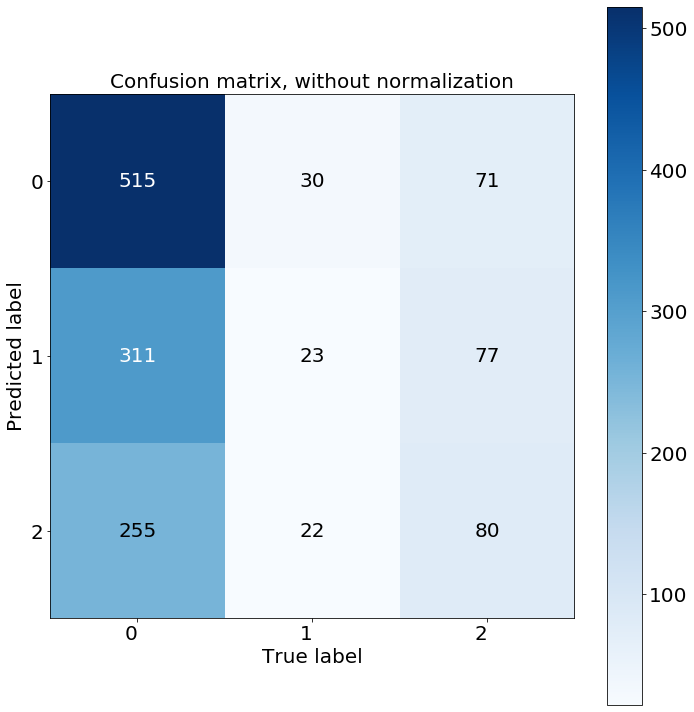

In [6]:
nclasses = 3
breakpoints = [750, 1500]

RandomForest(cf_matrix=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=10 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=10, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=20 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=20, total=   0.0s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  max_depth=2, min_samples_split=5, n_estimators=30, total=   0.1s
[CV] max_depth=2, min_samples_split=5, n_estimators=30 ...............
[CV]  

[CV]  max_depth=3, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] max_depth=3, min_samples_split=10, n_estimators=20 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=20, total=   0.0s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=3, min_samples_split=10, n_estimators=30 ..............
[CV]  max_depth=3, min_samples_split=10, n_estimators=30, total=   0.1s
[CV] max_depth=3, min_samples_split=15, n_estimators=10 ..............

[CV]  max_depth=4, min_samples_split=15, n_estimators=20, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=20 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=20, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=20 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=20, total=   0.0s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.1s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.1s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.1s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............
[CV]  max_depth=4, min_samples_split=15, n_estimators=30, total=   0.1s
[CV] max_depth=4, min_samples_split=15, n_estimators=30 ..............

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    7.7s finished


Best Grid Parameters :  {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}
accuracy: 0.30057803468208094
precision: 0.5168539325842697
recall: 0.672077922077922
f1score: 0.584333098094566
accuracy: 0.30057803468208094
precision: 0.25
recall: 0.0024330900243309003
f1score: 0.004819277108433735
accuracy: 0.30057803468208094
precision: 0.3333333333333333
recall: 0.0028011204481792717
f1score: 0.005555555555555556


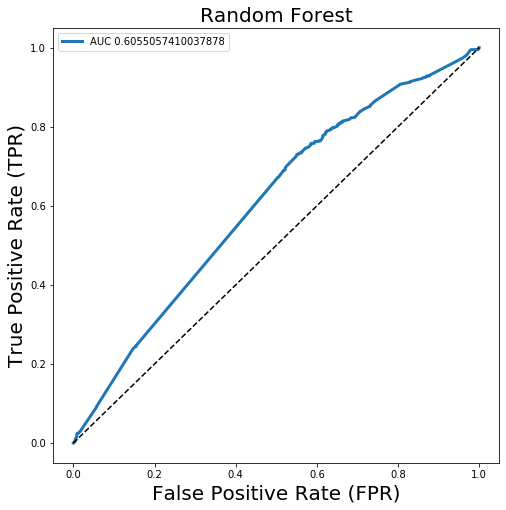

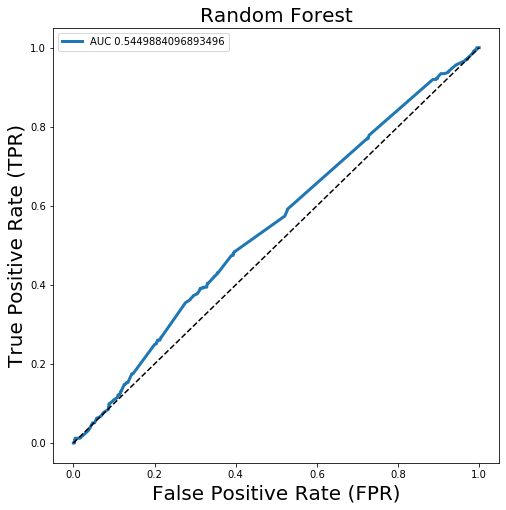

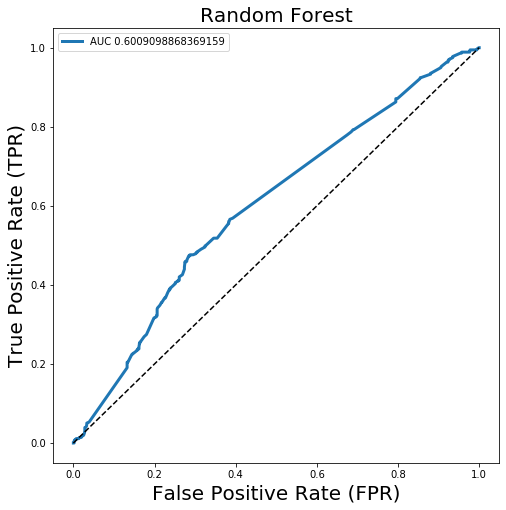

In [7]:
breakpoints = [750, 1500]
RandomForest(cf_matrix=False)